### Process Tiff Stack

In [1]:
from pvd_par import PVD

In [2]:
# Set paths
data_path = 'S:/pvd_data/'
dataset = 'DataSet01'
session = 'exp240202_01_E'
tiff_stack_path = f"{data_path}/{dataset}/{session}_/{session}.tif"

output_path = f"S:/pvd_analysis/{dataset}/{session}/"

# Original test worm: exp240202_01_E
#tiff_stack_path = 'A:/Git Repos/worm-warp/stacks/exp240202_01_E.tif'

In [3]:
# Plotly scatter3d of skeleton/nodes
save_plot = True
show_plot = False

In [4]:
# Execute pipeline
pvd = PVD(tiff_stack_path)
pvd.run_pipeline()

Starting pipeline
Loaded raw data with shape: (4, 188, 2044, 2042)
Cropped raw data to shape: (4, 188, 2000, 2000)
Skeletonizing timepoint 0
Skeletonizing timepoint 1
Skeletonizing timepoint 2
Skeletonizing timepoint 3
Completed skeletonizing timepoint 1
Completed skeletonizing timepoint 0
Completed skeletonizing timepoint 3
Completed skeletonizing timepoint 2
Skeletonized data shape: [(188, 2000, 2000), (188, 2000, 2000), (188, 2000, 2000), (188, 2000, 2000)]
Number of tips per timepoint: [117, 112, 117, 122]
Number of knots per timepoint: [342, 345, 335, 340]
Pipeline completed


In [5]:
# Save relevant numpy arrays
pvd.save_results(output_path, save_tiff=False)

In [6]:
pvd.skeletonized_data[0].dtype

dtype('uint8')

In [7]:
pvd.raw_data[0].dtype

dtype('float64')

### Visualize Output

In [8]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

AttributeError: 'str' object has no attribute 'astype'

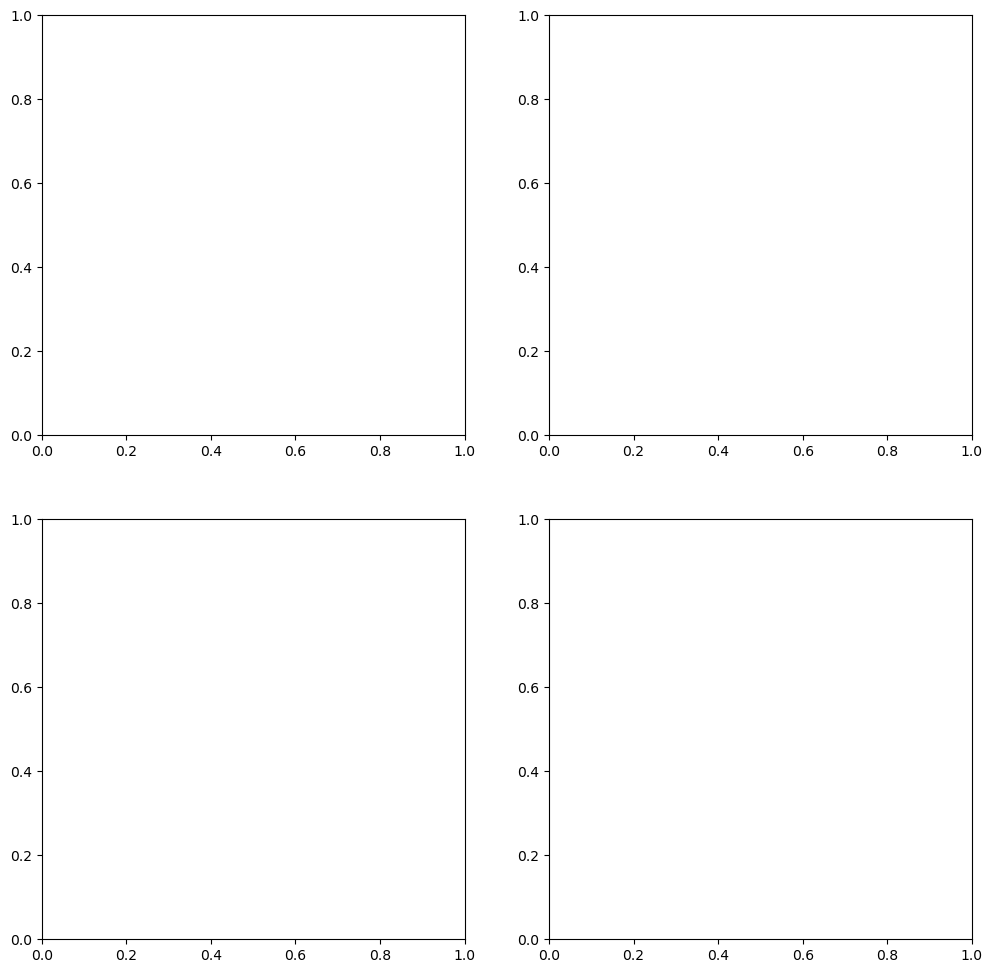

In [9]:
# Check out MIPs
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the axis array

for ii in range(4):
    axs[ii].imshow(pvd.mip_masks[ii].astype(np.uint8)*255)
    print(np.min(pvd.mip_masks[ii]))
    axs[ii].set_title(f'Timepoint {ii}')
    axs[ii].axis('off')

In [ ]:
from skimage import filters 
slice = pvd.raw_data[0,32,:,:]

yen_thresh = filters.threshold_yen(slice)


yen_mask = np.where(slice > yen_thresh, 1, 0)

81.0
0


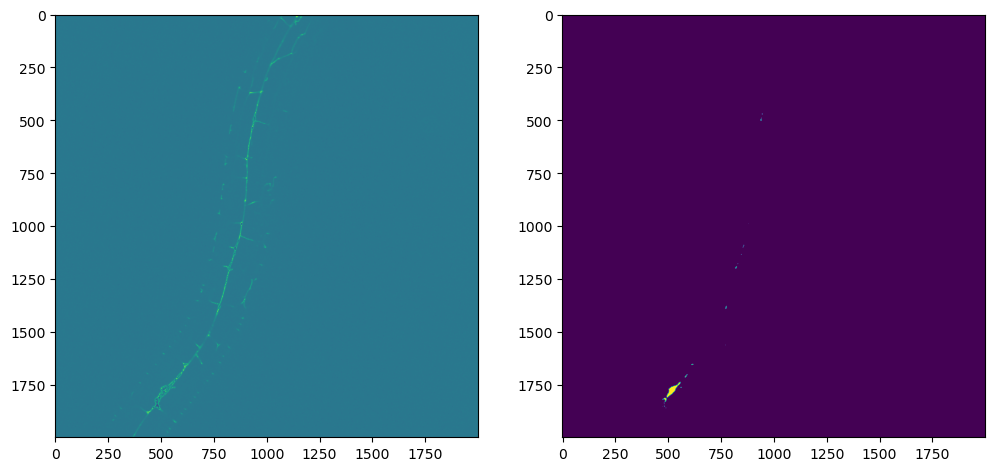

In [ ]:
# Check out MIPs
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the axis array


axs[0].imshow(slice.astype(np.uint8))
axs[1].imshow(yen_mask.astype(np.uint8))
print(np.min(slice))
print(np.min(yen_mask))


### Skeleton and Nodes

In [ ]:
# Timepoint of interest (0 to 3)
timepoint = 3

# Prepare skeleton data for plotting
image_stack = np.transpose(pvd.skeletonized_data[timepoint], (1, 2, 0))
x, y, z = image_stack.shape
Y, X, Z = np.meshgrid(np.arange(y), np.arange(x), np.arange(z))
colors = image_stack.ravel()

# Omit background (0-valued) voxels
visible_mask = colors != 0

# Extract coordinates for skeleton tips
tips_z = [point[0] for point in pvd.tips[timepoint]]
tips_x = [point[1] for point in pvd.tips[timepoint]]
tips_y = [point[2] for point in pvd.tips[timepoint]]

# Extract coordinates for skeleton knots
knot_z = [point[0] for point in pvd.knots[timepoint]]
knot_x = [point[1] for point in pvd.knots[timepoint]]
knot_y = [point[2] for point in pvd.knots[timepoint]]

# Plotly figure
fig = go.Figure()

# Skeleton tips
fig.add_trace(go.Scatter3d(
    x=tips_x,
    y=tips_y,
    z=tips_z,
    mode='markers',  # Use 'lines' for a line plot or 'markers+lines' for both
    marker=dict(
        size=5,
        color='red',  # You can customize the color
        opacity=.9
    )
))

# Skeleton knots
fig.add_trace(go.Scatter3d(
    x=knot_x,
    y=knot_y,
    z=knot_z,
    mode='markers',  # Use 'lines' for a line plot or 'markers+lines' for both
    marker=dict(
        size=4,
        color='blue',  # You can customize the color
        opacity=.9
    )
))

# Skeleton structure
fig.add_trace(go.Scatter3d(
    x=X.ravel()[visible_mask],
    y=Y.ravel()[visible_mask],
    z=Z.ravel()[visible_mask],
    mode='markers',
    marker=dict(
        size=2,
        color='black',
        colorscale='Viridis',
        opacity=.1
    )
))

# Update layout
fig.update_layout(
    title=f"C. Elegans PVD Neuron: <b>{session}</b><br>Timepoint: <b>{timepoint}</b>",
    scene=dict(
        xaxis_title='X (pixels)',
        yaxis_title='Y (pixels)',
        zaxis_title='Z (image index)',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=.2),  # Adjust z-axis scale if desired
        zaxis=dict(range=[0, pvd.skeletonized_data[timepoint].shape[0]]),  # Set z-axis bounds
        xaxis=dict(range=[0, pvd.skeletonized_data[timepoint].shape[1]]),  # Set x-axis bounds
        yaxis=dict(range=[0, pvd.skeletonized_data[timepoint].shape[2]]),  # Set y-axis bounds

    ),
    autosize=True

)

# Save the plot to an HTML file
if save_plot:
    pio.write_html(fig, file=f'S:/pvd_analysis/plots/{session}_skeleton_{timepoint}.html', auto_open=True)

# Show plot
if show_plot:
    fig.show()